In [1]:
from graph_ds import PyH3Graph
from pois_to_h3 import get_pois_h3
import pandas as pd
import h3.api.numpy_int as h3
import geopandas as gpd

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
graph = PyH3Graph()
graph.create(osm_path="../resources/copenhagen-processed.osm.pbf", gtfs_path="../resources/rejseplanen_GTFS.zip")

processing osm pbf file: ../resources/copenhagen-processed.osm.pbf
converted OSM file into 419384 edges
processing osm pbf file: ../resources/copenhagen-processed.osm.pbf
converted OSM file into 405422 edges
osm graph created with (350459,682406) nodes (walk,bike) in 26 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 33 s
merged graph created with 794860 nodes in 2 s
hash: 6672986726594103495


# Get Origins

In [3]:
from ghsl_processing import crop_tif_image, reproject_tif, tif_to_h3
# Open the raster file
tif_path= '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19.tif'
cropped_tif_file = '../resources/copenhagen_subset.tif'

# paste csv bounding box from this website https://boundingbox.klokantech.com/ 
bbox = [12.3999, 55.6059, 12.7456, 55.7652] # [xmin, ymin, xmax, ymax]

# CROP
# cropping crs from latlon --> tif crs
src_crs = 'EPSG:4326'
dst_crs = 'ESRI:54009'
crop_tif_image(tif_path, cropped_tif_file, bbox, src_crs, dst_crs)

# Reproj
# reprojection goes from tif crs --> latlon 
src_crs = 'ESRI:54009'
dst_crs = 'EPSG:4326'
reprojected_file = '../resources/reprojected_copenhagen.tif'
transformation = reproject_tif(cropped_tif_file, dst_crs, reprojected_file)

H3_RES = 12
h3_csv = '../resources/ghsl_h3_codes.csv'
tif_to_h3(reprojected_file, transformation, h3_csv, H3_RES)

origins = pd.read_csv(h3_csv)
# only take residential, convert to list of h3 indices
origins = list(origins[origins['residential_bool']==1]['h3_index'])

# Get Destinations

In [4]:
pbf_path = "../resources/copenhagen-processed.osm.pbf"

# idea: EVERYONE can use it and live a healthy life with this as their only source
#check: doctors, clinic, health_food, food
#essential filter will be the least restrictive!

# frequency arguments - how often do you use these?
# no workplace - motivate this... unrealistic to get data, and for people to work within 15 minutes of their homes
essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors","school"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park"], "sport":True
    }

# parameters

H3_RES = 12

# n minute city must satisfy the following expression based on
# the existence of certain tags within n minutes:
category_set = set(['pharmacy','park','supermarket','sport', 'education'])

# easy use case which is debateably also essential
#education_filter = {"amenity":["school"]}

osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport'
}

h3_df = get_pois_h3(pbf_path, essential_filter, H3_RES, category_set, osm_tag_mapping)

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/12/2680/1903.png

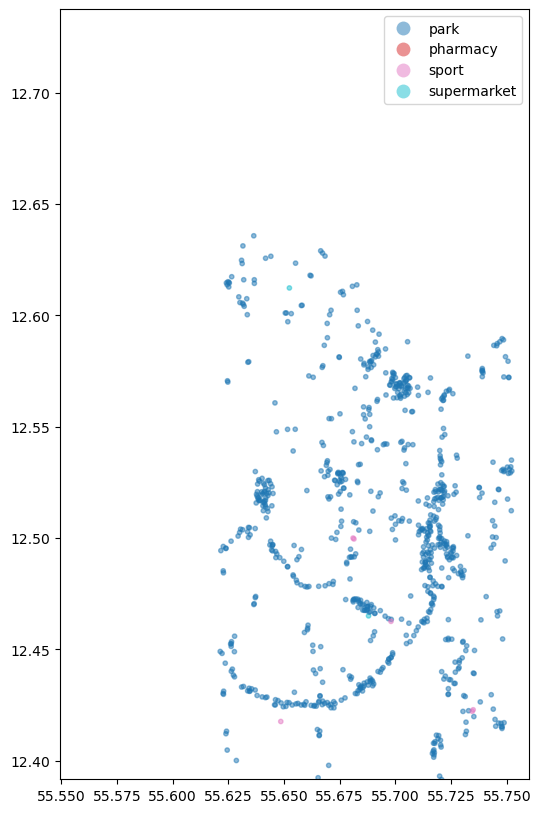

In [62]:
sample_df = h3_df.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', categorical=True, legend=True, markersize=10, alpha=0.5)

# denmark
#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

# middle east
plt.ylim(12.391681,12.737388)
plt.xlim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_71077/4221512576.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])


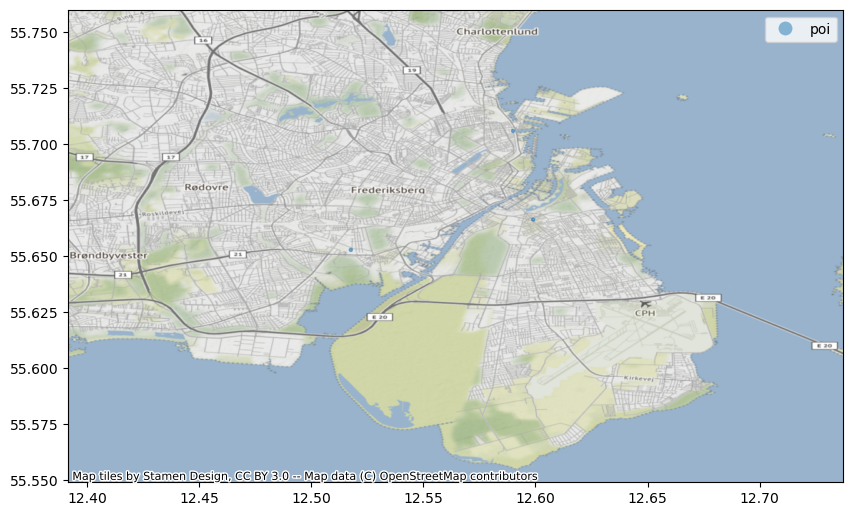

In [56]:
h3_df['hex_type'] = 'poi'
origins = pd.read_csv(h3_csv)
origins = origins[origins['residential_bool']==1]
origins['hex_type'] = 'building_type'
combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])

combined = combined[combined['hex_type']=='poi']

sample_df = combined.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='hex_type', categorical=True, legend=True, markersize=5, alpha=0.5)

plt.xlim(12.391681,12.737388)
plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

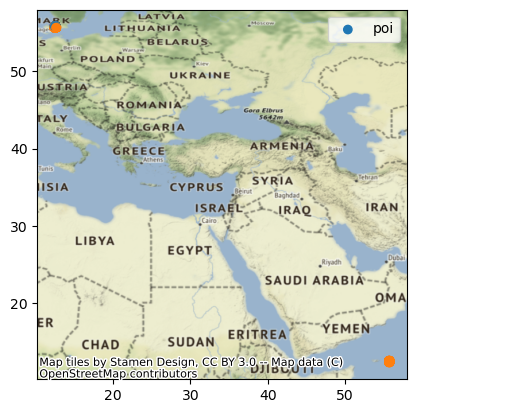

In [48]:
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt

df = combined.sample(1000)

colors = {'poi':'tab:blue', 'building_type':'tab:orange'}

fig, ax = plt.subplots()

ax.scatter(x=df['lon'], y=df['lat'], c=df['hex_type'].map(colors))
plt.legend(['poi','building_type'])

#combined.plot(kind='scatter', y='lat',x='lon',c='hex_type')

cx.add_basemap(ax = ax, crs="EPSG:4326")

In [5]:
destinations = list(h3_df[h3_df['category']=='supermarket']['h3_index'])

In [13]:
ds = graph.matrix_distance(origins=origins[:100], destinations=destinations[:100], hour_of_week = None)

In [17]:
origins[:100]

[631049687957842431,
 631049687957842943,
 631049687957847039,
 631049687956867071,
 631049687956851199,
 631049687956871167,
 631049687956901375,
 631049687956900863,
 631049687956905471,
 631049687956305407,
 631049687956305919,
 631049687957137407,
 631049687957121535,
 631049687957125631,
 631049687957126143,
 631049687957168639,
 631049687957171199,
 631049687957144063,
 631049687957148671,
 631049687960077823,
 631049687960078335,
 631049687960077311,
 631049687960067071,
 631049687960004607,
 631049687959882239,
 631049687959882751,
 631049687959887359,
 631049687959884287,
 631049687959886847,
 631049687960039935,
 631049687960040447,
 631049687958513151,
 631049687958513663,
 631049687958497791,
 631049687958318591,
 631049687958318079,
 631049687958294015,
 631049687958290943,
 631049687958295039,
 631049687958295551,
 631049687958563839,
 631049687958561791,
 631049687958568447,
 631049687958600191,
 631049687958590975,
 631049687894447615,
 631049687894446591,
 631049687894

In [15]:
ds

{631049687858374143: [inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf],
 631049687858202623: [59.02800853789987,
  54.6689686253999,
  56.761307783399886,
  65.75836616280009,
  58.504923748399875,
  55.78488284299989,
  54.1110115165999,
  56.58694618689989,
  51.983800039299915,
  58.85364694139987,
  55.1023817366999,
  51.25148133399992,
  57.563371127

In [7]:
dist_result = graph.matrix_bfs(
    origins=[631049690224658431, 631049690149925887], 
    destinations=[631049690192976895, 631049690183383551])

dist_result

[[12.129702357249998], [11.345075172999998]]

In [8]:
# if poi is not in the graph, we search with kring size 1, if still not found, return empty list
%%time
dist_result = graph.matrix_bfs(origins=[631049690224658431, 631049690149925887], destinations=[631049690149925887, 631049690224658431])

UsageError: Line magic function `%%time` not found.


In [9]:
dist_result

[[12.129702357249998], [11.345075172999998]]